## Part IV: VGG-13 Implementation

In [2]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import time
import torch

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

In [5]:
# Define tranform
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
# Load the EMNIST dataset
emnist_dataset = datasets.ImageFolder(root='./dataset/cnn_dataset/cnn_dataset', transform=transform)

In [7]:
# Define sizes of train, test and validation data as 70:15:15 of dataset
train_size = int(0.7 * len(emnist_dataset))
val_size = int(0.15 * len(emnist_dataset))
test_size = len(emnist_dataset) - train_size - val_size

In [8]:
# Split the dataset in train, test and validation data
train_dataset, val_dataset, test_dataset = random_split(emnist_dataset, [train_size, val_size, test_size])

In [9]:
# Create data loaders for train, test and validation data
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
import torch
import torch.nn as nn

#### 1. Implement the VGG-13 (VersionB) architecture following the proposed architecture and adjusting it to fit our dataset.

#### 2. Adjustments based on your dataset:
<ol type='a'>
    <li>The input size for the original VGG is 224x224.</li>
    <p>Here are a few options:</p>
    <ol type='i'>
        <li>You can remove a few max pooling layers.</li>
        <li>Add padding to your convolutional layers to maintain more spatial dimensions.</li>
        <li>Resize your input size</li>
    </ol>
    <li>The last layer of the original VGG contains 1000 classes. You can modify it to fit the number of your classes (e.g. 36).</li>
</ol>

#### 3. Use the dropout and learning rate scheduler, as in the VGG paper

In [11]:
# Define VGG architect with the modifications as per EMNIST dataset
class VGG13(nn.Module):
    def __init__(self, num_classes=36):
        super(VGG13, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )

        # Initialize weights
        self._initialize_wt()

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_wt(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [12]:
# Instantiate the model with 36 classes
model = VGG13(num_classes=36)

In [13]:
import torch.optim as optim
from torch.optim import lr_scheduler

In [14]:
# Define loss function, optimizer and scheduler
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

#### 4. Train the model on a dataset used in Part III (EMNIST).

In [15]:
# Method to train the model using early stopping
def train_model(model, train_loader, val_loader, loss_function, optimizer, scheduler, num_epochs=20, patience=5):

    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        scheduler.step()
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        # Validating the model
        model.eval()
        with torch.no_grad():
            val_running_loss, val_correct, val_total = 0.0, 0, 0
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_acc = 100. * val_correct / val_total
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%")

        # Checking for early stopping
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    return train_acc, val_acc, train_loss, val_loss

start_time = time.time()
train_acc, val_acc, train_loss, val_loss = train_model(model, train_loader, val_loader, loss_function, optimizer, scheduler, num_epochs=20, patience=5)
training_time = time.time() - start_time

Epoch [1/20], Train Loss: 1.7755, Train Acc: 48.66%, Val Loss: 0.3849, Val Acc: 86.14%
Epoch [2/20], Train Loss: 0.3390, Train Acc: 87.74%, Val Loss: 0.2769, Val Acc: 89.58%
Epoch [3/20], Train Loss: 0.2608, Train Acc: 90.14%, Val Loss: 0.2510, Val Acc: 91.00%
Epoch [4/20], Train Loss: 0.2245, Train Acc: 91.30%, Val Loss: 0.2601, Val Acc: 90.64%
Epoch [5/20], Train Loss: 0.2036, Train Acc: 91.98%, Val Loss: 0.2613, Val Acc: 90.80%
Epoch [6/20], Train Loss: 0.1877, Train Acc: 92.45%, Val Loss: 0.2328, Val Acc: 91.81%
Epoch [7/20], Train Loss: 0.1745, Train Acc: 92.77%, Val Loss: 0.2425, Val Acc: 91.54%
Epoch [8/20], Train Loss: 0.1693, Train Acc: 92.96%, Val Loss: 0.2362, Val Acc: 91.45%
Epoch [9/20], Train Loss: 0.1597, Train Acc: 93.33%, Val Loss: 0.2336, Val Acc: 92.12%
Epoch [10/20], Train Loss: 0.1568, Train Acc: 93.45%, Val Loss: 0.2377, Val Acc: 91.58%
Epoch [11/20], Train Loss: 0.1184, Train Acc: 94.86%, Val Loss: 0.2215, Val Acc: 92.24%
Epoch [12/20], Train Loss: 0.1092, Train 

#### 5. Evaluate the performance of the model on the testing data and visualize the results. Follow Part III, Steps 6&7

In [19]:
from sklearn.metrics import precision_recall_fscore_support
import torch

model = model.to(device)
model.eval()
correct = 0
total = 0
model_labels = []
model_preds = []
test_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        model_labels.extend(labels.cpu().numpy())
        model_preds.extend(predicted.cpu().numpy())

        loss = loss_function(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculating test loss
test_loss /= total

# Calculating test accuracy
test_accuracy = 100 * correct / total

# Calculating precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(model_labels, model_preds, average='macro')

print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Training Time: {training_time:.2f} seconds")

Test Accuracy: 91.84%
Precision: 0.9191
Recall: 0.9185
F1 Score: 0.9179
Training Time: 903.07 seconds


In [30]:
# Save the weights of the model
torch.save(model.state_dict(), 'swetasah_assignment2_part_4.pth')

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

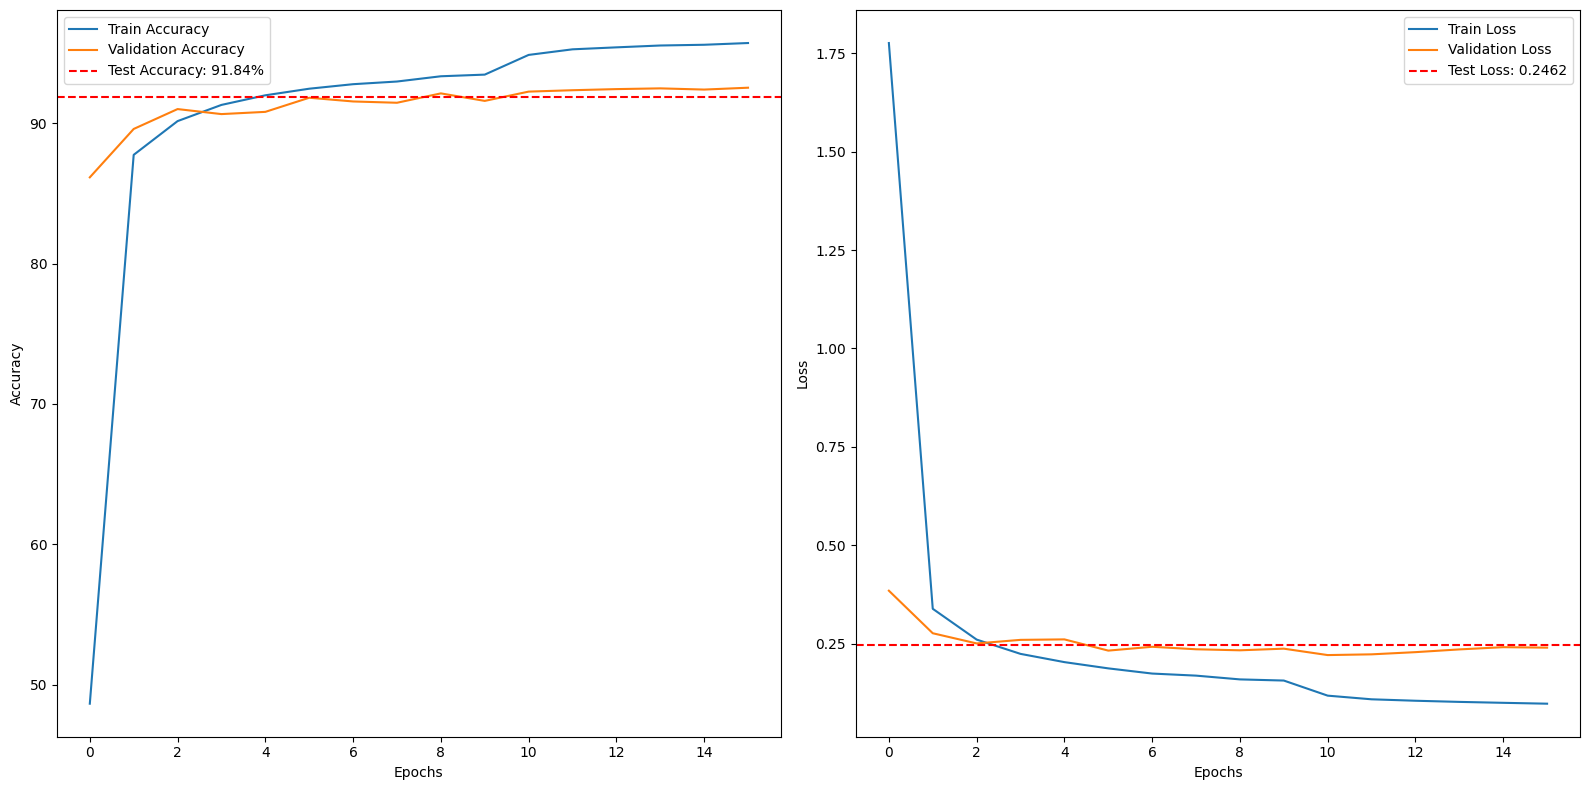

In [22]:
# Plotting train, validation and test accuracy and loss
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.axhline(test_accuracy, color='r', linestyle='--', label=f"Test Accuracy: {test_accuracy:.2f}%")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.axhline(test_loss, color='r', linestyle='--', label=f"Test Loss: {test_loss:.4f}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

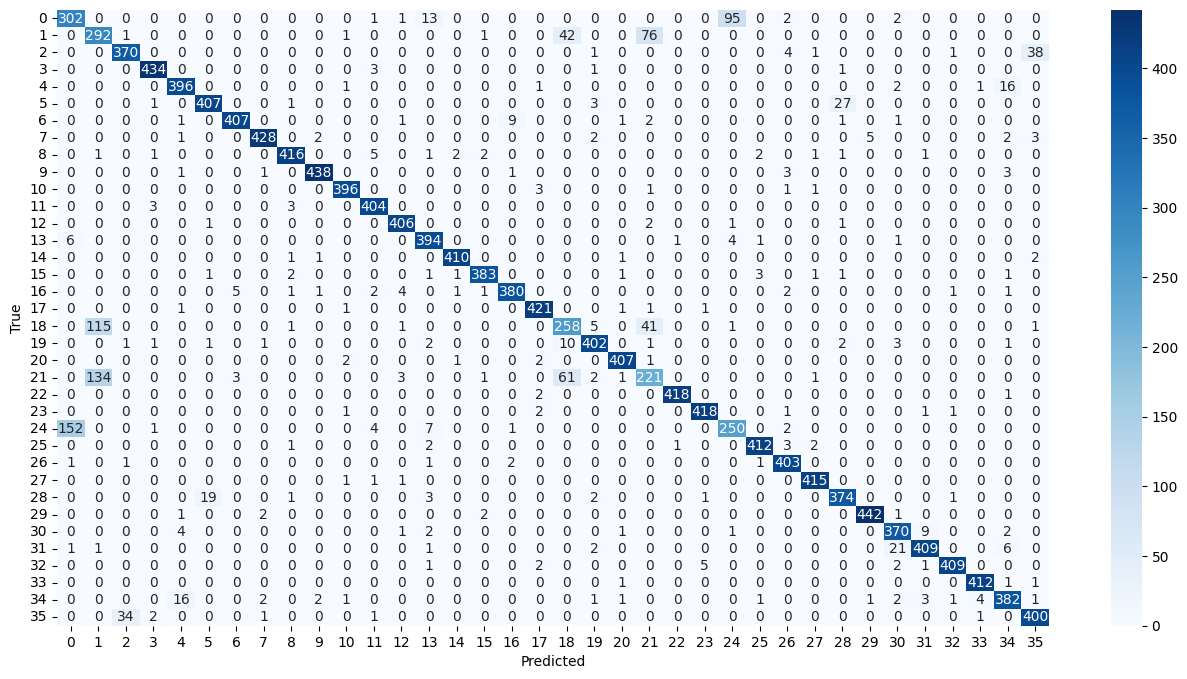

In [26]:
# Confusion Matrix
model = model.to(device)
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(16, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

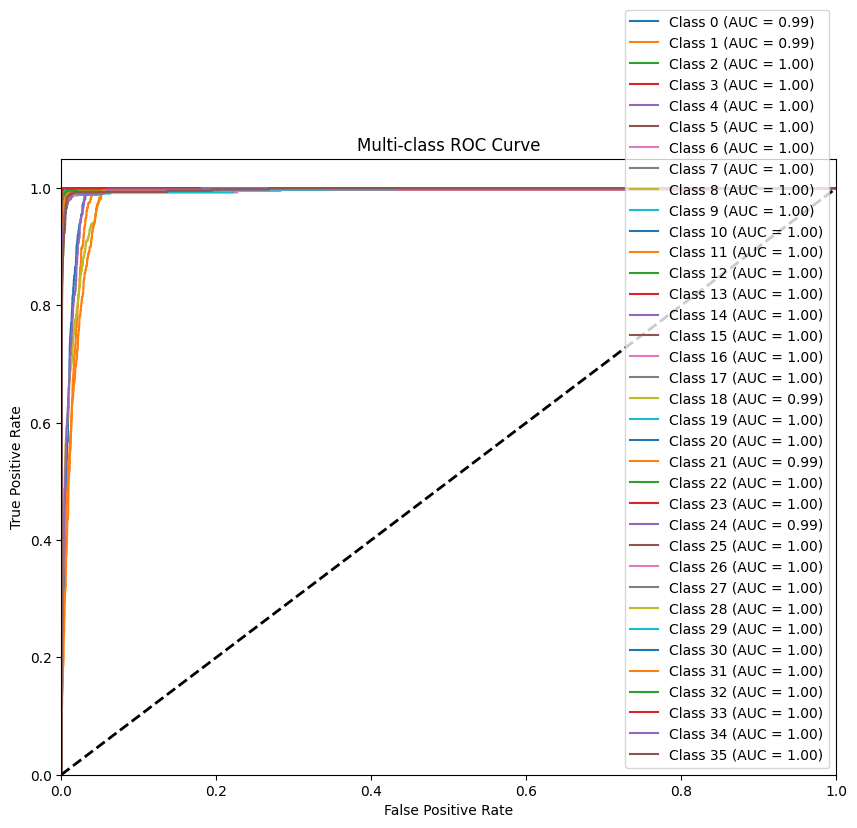

In [29]:
# Plotting ROC Curve
from torchmetrics.classification import MulticlassROC, MulticlassAUROC
from sklearn.metrics import roc_auc_score

model = model.to(device)
model.eval()
softmax = torch.nn.Softmax(dim=1)
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = softmax(outputs)
        all_probs.append(probs)
        all_labels.append(labels)

all_probs = torch.cat(all_probs)
all_labels = torch.cat(all_labels)

n_classes = len(emnist_dataset.classes)

# Initializing ROC and AUROC
roc = MulticlassROC(num_classes=n_classes)
auroc = MulticlassAUROC(num_classes=n_classes)

# Computing ROC
fpr, tpr, _ = roc(all_probs, all_labels)

# Computing AUC for each class
auc_scores = []
for i in range(n_classes):
    auc = roc_auc_score(all_labels.cpu().numpy() == i, all_probs.cpu().numpy()[:, i])
    auc_scores.append(auc)

# Plotting ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i].cpu().numpy(), tpr[i].cpu().numpy(), label=f'Class {i} (AUC = {auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()

#### References

In [31]:
# https://arxiv.org/pdf/1409.1556